In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

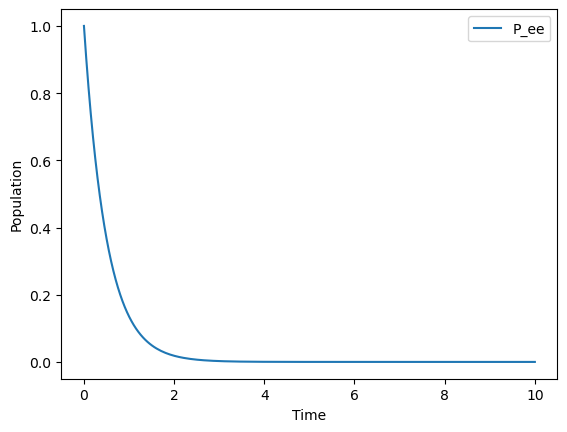

In [5]:
g = qt.basis(2, 0)
e = qt.basis(2, 1)

ge = qt.tensor(g, e)
eg = qt.tensor(e, g)
gg = qt.tensor(g, g)
ee = qt.tensor(e, e)

s = (eg + ge).unit()
a = (eg - ge).unit()

P_ee = qt.ket2dm(ee)
P_gg = qt.ket2dm(gg)
P_ss = qt.ket2dm(s)
P_aa = qt.ket2dm(a)

dim = P_ee.shape[0]

ħ = 1.0
ω_0 = 1.0
Ω_12 = 0.5
H_as = ħ * ( ω_0 * (P_ee - P_gg) + Ω_12 * (P_ss - P_aa) )

Γ = 1.0
Γ_12 = 0.8

L_s = np.sqrt(Γ + Γ_12) * (s * ee.dag() + gg * s.dag())
L_a = np.sqrt(Γ - Γ_12) * (a * ee.dag() - gg * a.dag())


rho0 = qt.ket2dm(ee)

tlist = np.linspace(0, 10, 200)

result = qt.mesolve(H_as, rho0, tlist, c_ops = [L_s, L_a], e_ops = [])

expect_ee = qt.expect(P_ee, result.states)

plt.plot(tlist, expect_ee, label='P_ee')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()


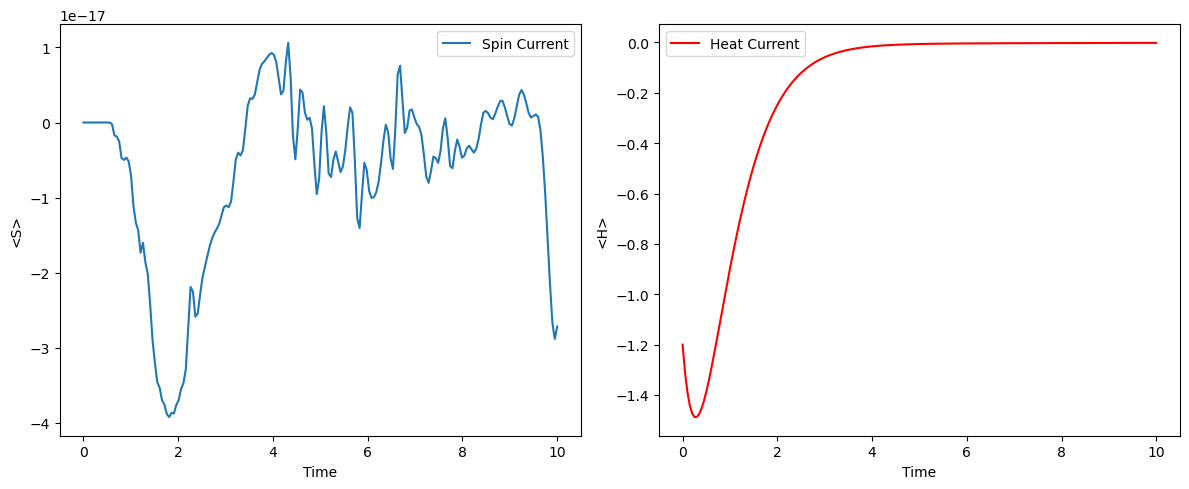

In [9]:
sigmap = qt.sigmap()
sigmam = qt.sigmam()
J_spin_op = 1j * (qt.tensor(sigmap, sigmam) - qt.tensor(sigmam, sigmap))
spin_current = qt.expect(J_spin_op, result.states)

def lindblad_heat_current(H, rho, L):
    D = L * rho * L.dag() - 0.5 * (L.dag() * L * rho + rho * L.dag() * L)
    return np.real((H * D).tr())

heat_current = [lindblad_heat_current(H_as, state, L_s) +
                lindblad_heat_current(H_as, state, L_a)
                for state in result.states]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tlist, spin_current, label='Spin Current')
plt.xlabel('Time')
plt.ylabel(f'<S>')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tlist, heat_current, label='Heat Current', color='red')
plt.xlabel('Time')
plt.ylabel(f'<H>')
plt.legend()

plt.tight_layout()
plt.show()

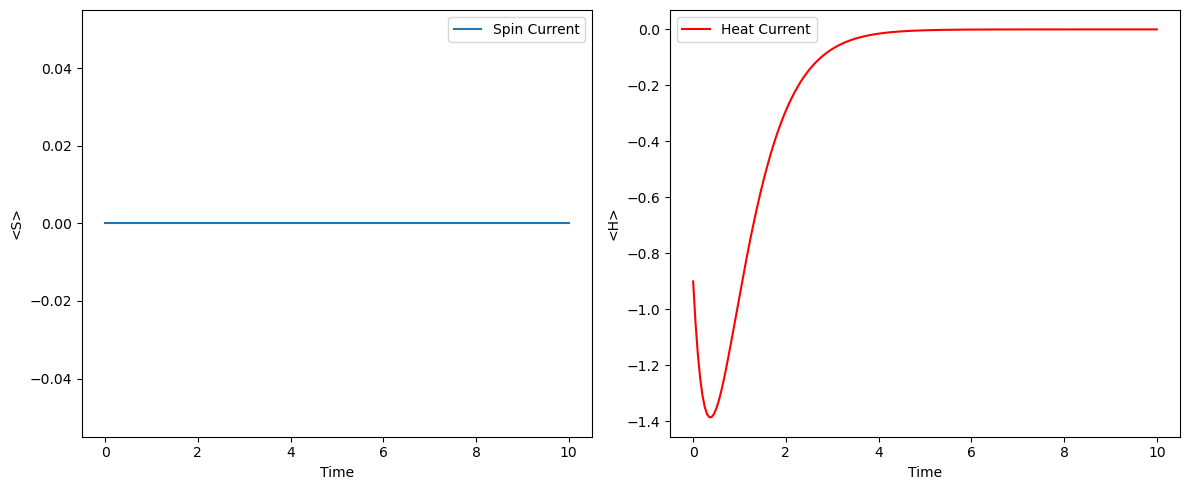

In [10]:
result = qt.mesolve(H_as, rho0, tlist, c_ops = [L_s], e_ops = [])

sigmap = qt.sigmap()
sigmam = qt.sigmam()
J_spin_op = 1j * (qt.tensor(sigmap, sigmam) - qt.tensor(sigmam, sigmap))
spin_current = qt.expect(J_spin_op, result.states)

def lindblad_heat_current(H, rho, L):
    D = L * rho * L.dag() - 0.5 * (L.dag() * L * rho + rho * L.dag() * L)
    return np.real((H * D).tr())

heat_current = [lindblad_heat_current(H_as, state, L_s) for state in result.states]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tlist, spin_current, label='Spin Current')
plt.xlabel('Time')
plt.ylabel(f'<S>')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tlist, heat_current, label='Heat Current', color='red')
plt.xlabel('Time')
plt.ylabel(f'<H>')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

ħ = 1.0
ω_1 = ω_2 = 1.0
Ω_12 = 0.1
Γ = 1.0
C_12 = 0.8 * Γ

N_th = 0.1
r = 0.5
ϕ = 0.5

N_eff = N_th * (np.cosh(r)**2 + np.sinh(r)**2) + np.sinh(r)**2
M = -0.5 * np.sinh(2 * r) * np.exp(1j * ϕ) * (2 * N_th + 1)

In [33]:
sm_1 = qt.tensor(qt.sigmam(), qt.qeye(2))
sm_2 = qt.tensor(qt.qeye(2), qt.sigmam())
sp_1 = sm_1.dag()
sp_2 = sm_2.dag()

sz_1 = qt.tensor(qt.sigmaz(), qt.qeye(2)) / 2
sz_2 = qt.tensor(qt.qeye(2), qt.sigmaz()) / 2

In [34]:
H = ħ * (ω_1 * sz_1 + ω_2 * sz_2) + ħ * Ω_12 * (sp_1 * sm_2 + sp_2 * sm_1)

In [35]:
C = np.array([[Γ, C_12],
              [C_12, Γ]])

sp = [sp_1, sp_2]
sm = [sm_1, sm_2]

def D(A, B, rho):
    return 2 * A * rho * B - B * A * rho - rho * B * A

def L_total(rho):
    L = 0
    for i in range(2):
        for j in range(2):
            cij = C[i][j]
            L += (cij / 2) * (1 + N_eff) * D(sm[j], sp[i], rho)
            L += (cij / 2) * N_eff * D(sp[j], sm[i], rho)
            L += (cij / 2) * M * D(sm[j], sm[i], rho)
            L += (cij / 2) * np.conj(M) * D(sp[j], sp[i], rho)
    return L

In [36]:
ρ_0 = qt.tensor(qt.basis(2,1), qt.basis(2,1)) * qt.tensor(qt.basis(2,1), qt.basis(2,1)).dag()

tlist = np.linspace(0, 10, 200)

ρ_t = []

ρ = ρ_0
dt = tlist[1] - tlist[0]

for t in tlist:
    ρ_t.append(rho)
    dρdt = -1j * (H * ρ - ρ * H) + L_total(ρ)
    ρ = ρ + dt * dρdt

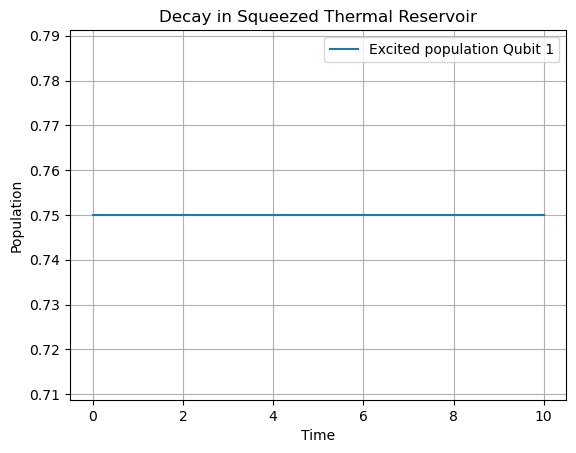

In [37]:
P_e1 = qt.tensor(qt.basis(2,1)*qt.basis(2,1).dag(), qt.qeye(2))
exp_e1 = [qt.expect(sz_1, r) for r in ρ_t]
exp_e1 = 0.5 * (1 - np.asarray(exp_e1))

plt.plot(tlist, exp_e1, label='Excited population Qubit 1')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Decay in Squeezed Thermal Reservoir")
plt.grid()
plt.legend()
plt.show()

In [17]:
P_ee = qt.tensor(qt.basis(2,1) * qt.basis(2,1).dag(), qt.basis(2,1) * qt.basis(2,1).dag())
P_gg = qt.tensor(qt.basis(2,0) * qt.basis(2,0).dag(), qt.basis(2,0) * qt.basis(2,0).dag())

exp_ee = [qt.expect(P_ee, r) for r in ρ_t]
exp_gg = [qt.expect(P_gg, r) for r in ρ_t]

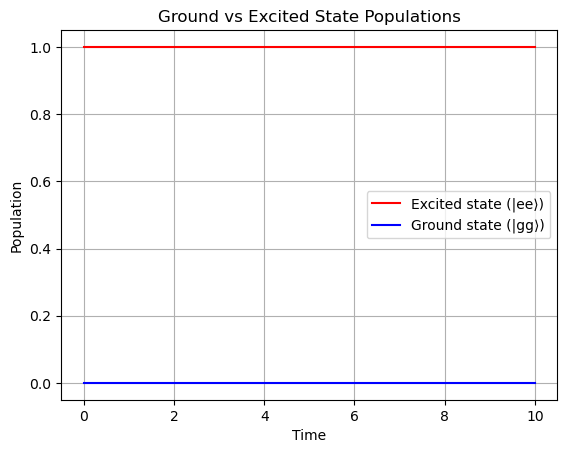

In [18]:
plt.plot(tlist, exp_ee, label='Excited state (|ee⟩)', color='red')
plt.plot(tlist, exp_gg, label='Ground state (|gg⟩)', color='blue')
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Ground vs Excited State Populations")
plt.legend()
plt.grid()
plt.show()

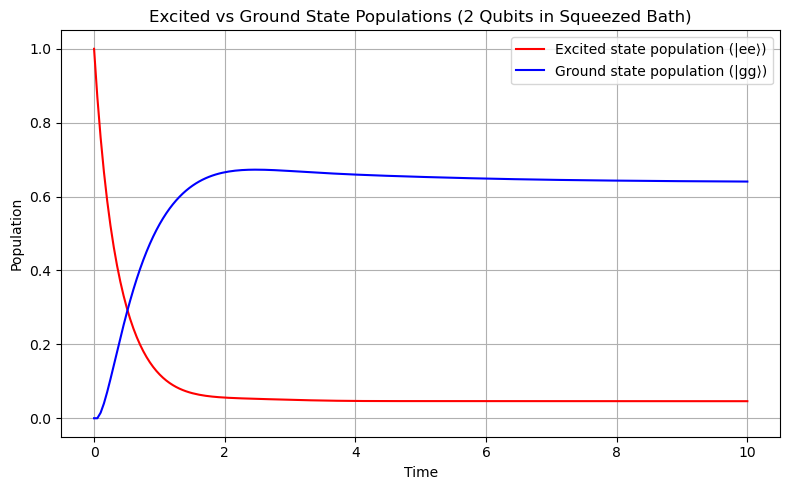

In [26]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# PARAMETERS
# ----------------------------
ħ = 1.0
ω1 = ω2 = 1.0        # Atomic transition frequencies
Ω_12 = 0.1            # Coherent dipole-dipole interaction
Γ = 1.0              # Individual decay rate
Γ_12 = 0.8 * Γ        # Collective decay rate

N_th = 0.1           # Thermal photon number
r = 0.4              # Squeezing parameter
phi = 0.0            # Squeezing phase

# Derived squeezed bath parameters
N_eff = N_th * (np.cosh(r)**2 + np.sinh(r)**2) + np.sinh(r)**2
M = -0.5 * np.sinh(2 * r) * np.exp(1j * phi) * (2 * N_th + 1)

# ----------------------------
# BASIS OPERATORS
# ----------------------------
sm = 0.5 * (sigmax() - 1j * sigmay())
sp = 0.5 * (sigmax() + 1j * sigmay())
sm1 = tensor(sm, qeye(2))     # σ₋ on qubit 1
sm2 = tensor(qeye(2), sm)     # σ₋ on qubit 2
sp1 = sm1.dag()
sp2 = sm2.dag()

sz1 = tensor(sigmaz(), qeye(2)) / 2
sz2 = tensor(qeye(2), sigmaz()) / 2

# ----------------------------
# HAMILTONIAN He
# ----------------------------
H_s = ħ * (ω1 * sz1 + ω2 * sz2) + ħ * Ω_12 * (sp1 * sm2 + sp2 * sm1)

# ----------------------------
# CUSTOM LINDBLAD SUPEROPERATOR
# ----------------------------
C = np.array([[Γ, Γ_12],
              [Γ_12, Γ]])

sp = [sp1, sp2]
sm = [sm1, sm2]

def D(A, B, rho):
    return 2 * A * rho * B - B * A * rho - rho * B * A

def L_total(rho):
    L = 0
    for i in range(2):
        for j in range(2):
            cij = C[i][j]
            # Emission
            L += (cij / 2) * (1 + N_eff) * D(sm[j], sp[i], rho)
            # Absorption
            L += (cij / 2) * N_eff * D(sp[j], sm[i], rho)
            # Squeezing terms
            L += (cij / 2) * M * D(sp[j], sp[i], rho)
            L += (cij / 2) * np.conj(M) * D(sm[j], sm[i], rho)
    return L

# ----------------------------
# INITIAL STATE
# ----------------------------
rho0 = tensor(basis(2, 0), basis(2, 0)) * tensor(basis(2, 0), basis(2, 0)).dag()  # |ee⟩

# ----------------------------
# TIME EVOLUTION (manual Euler)
# ----------------------------
tlist = np.linspace(0, 10, 200)
dt = tlist[1] - tlist[0]
rho_t = []

rho = rho0
for t in tlist:
    rho_t.append(rho)
    drho = -1j * (H_s * rho - rho * H_s) + L_total(rho)
    rho = rho + dt * drho

# ----------------------------
# POPULATION OPERATORS
# ----------------------------
P_ee = tensor(basis(2, 0), basis(2, 0)) * tensor(basis(2, 0), basis(2, 0)).dag()
P_gg = tensor(basis(2, 1), basis(2, 1)) * tensor(basis(2, 1), basis(2, 1)).dag()

pop_ee = [expect(P_ee, r) for r in rho_t]
pop_gg = [expect(P_gg, r) for r in rho_t]

# ----------------------------
# PLOT RESULTS
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(tlist, pop_ee, label='Excited state population (|ee⟩)', color='red')
plt.plot(tlist, pop_gg, label='Ground state population (|gg⟩)', color='blue')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Excited vs Ground State Populations (2 Qubits in Squeezed Bath)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# ----------------------------
# SPIN & HEAT CURRENT
# ----------------------------

Js_list = []
Jh_list = []

for rho in rho_t:
    # Spin current: J_s = iħ Ω_12 ⟨S1⁺S2⁻ - S2⁺S1⁻⟩
    Js_op = 1j * ħ * Ω_12 * (sp1 * sm2 - sp2 * sm1)
    Js_list.append(expect(Js_op, rho))

    # Heat current: Jh = Tr[H_s * L_total(rho)]
    Jh_list.append(np.real((H_s * L_total(rho)).tr()))

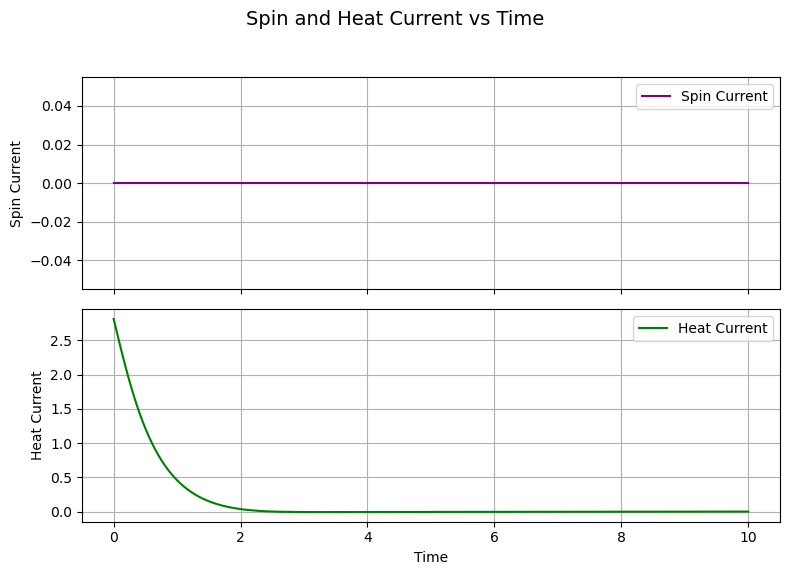

In [33]:
# ----------------------------
# PLOT HEAT AND SPIN CURRENT
# ----------------------------
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(tlist, Js_list, label='Spin Current', color='purple')
axs[0].set_ylabel("Spin Current")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(tlist, Jh_list, label='Heat Current', color='green')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Heat Current")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Spin and Heat Current vs Time", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

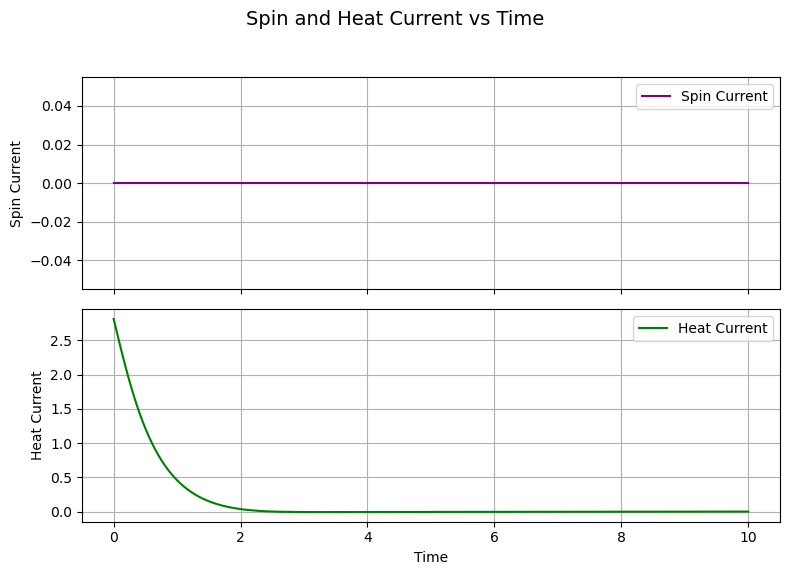

In [31]:
# ----------------------------
# PLOT HEAT AND SPIN CURRENT
# ----------------------------
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(tlist, Js_list, label='Spin Current', color='purple')
axs[0].set_ylabel("Spin Current")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(tlist, Jh_list, label='Heat Current', color='green')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Heat Current")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Spin and Heat Current vs Time", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


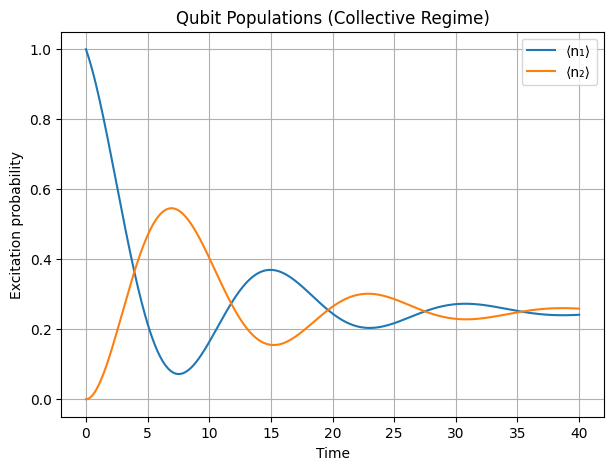

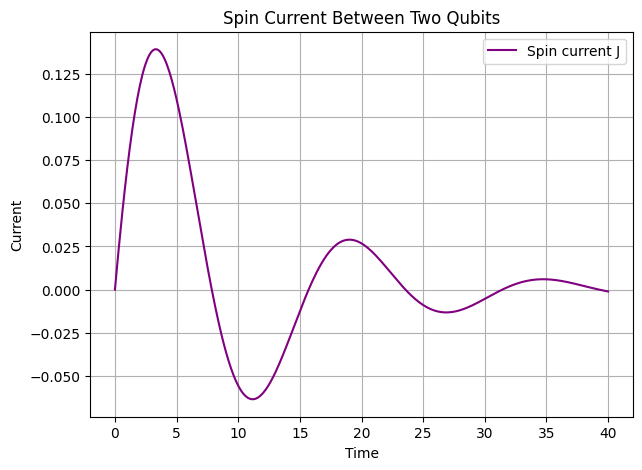

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
g = 0.2       # qubit-qubit coupling strength
gamma = 0.1   # collective decay rate
w = 1.0       # qubit frequency
N = 2         # number of qubits

# Operators
sm_list = [tensor([destroy(2) if m==n else qeye(2) for m in range(N)]) for n in range(N)]
sp_list = [sm.dag() for sm in sm_list]
sz_list = [sigmaz() if n==0 else qeye(2) for n in range(N)]  # just for checking

# Hamiltonian: two qubits + exchange interaction
H0 = w * (sm_list[0].dag()*sm_list[0] + sm_list[1].dag()*sm_list[1])
H_int = g * (sp_list[0]*sm_list[1] + sp_list[1]*sm_list[0])
H = H0 + H_int

# Collective collapse operator
J = sum(sm_list)   # collective lowering operator
c_ops = [np.sqrt(gamma) * J]

# Initial state: one qubit excited, other in ground
psi0 = tensor(basis(2,1), basis(2,0))

# Time evolution
tlist = np.linspace(0, 40, 400)
result = mesolve(H, psi0, tlist, c_ops, 
                 e_ops=[sm_list[0].dag()*sm_list[0], 
                        sm_list[1].dag()*sm_list[1],
                        1j*g*(sp_list[0]*sm_list[1] - sp_list[1]*sm_list[0])])

# Extract results
n1 = result.expect[0]   # excitation of qubit 1
n2 = result.expect[1]   # excitation of qubit 2
Jcur = np.real(result.expect[2])  # spin current

# Plot populations
plt.figure(figsize=(7,5))
plt.plot(tlist, n1, label="⟨n₁⟩")
plt.plot(tlist, n2, label="⟨n₂⟩")
plt.xlabel("Time")
plt.ylabel("Excitation probability")
plt.legend()
plt.title("Qubit Populations (Collective Regime)")
plt.grid()
plt.show()

# Plot spin current
plt.figure(figsize=(7,5))
plt.plot(tlist, Jcur, label="Spin current J", color='purple')
plt.xlabel("Time")
plt.ylabel("Current")
plt.legend()
plt.title("Spin Current Between Two Qubits")
plt.grid()
plt.show()


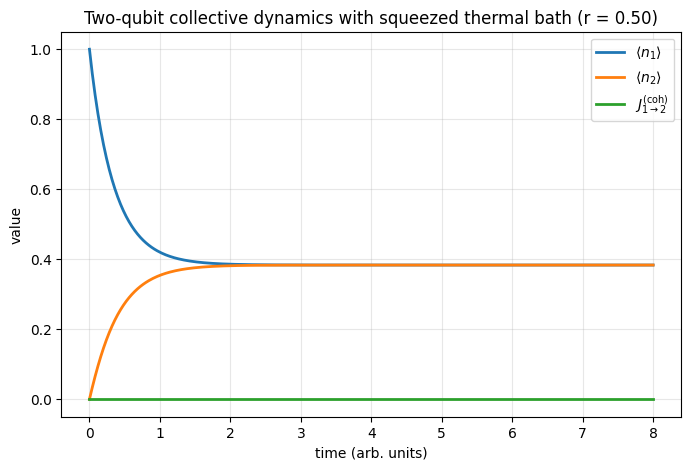

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
g = 0.0       # coherent exchange set to zero (focus on bath effects)
gamma = 1.0   # decay rate
w = 1.0       # qubit frequency
r = 0.5       # squeezing parameter
phi = 0.0     # squeezing phase

# Derived parameters
N = np.sinh(r)**2
M = np.sinh(r) * np.cosh(r) * np.exp(1j*phi)

# Two qubits
Nq = 2
sm_list = [tensor([destroy(2) if m==n else qeye(2) for m in range(Nq)]) for n in range(Nq)]
sp_list = [sm.dag() for sm in sm_list]
sz_list = [tensor([sigmaz() if m==n else qeye(2) for m in range(Nq)]) for n in range(Nq)]

# Collective operators
J = sum(sm_list)
Jdag = J.dag()

# Hamiltonian: no direct coupling (only bath-induced)
H = w*(sm_list[0].dag()*sm_list[0] + sm_list[1].dag()*sm_list[1])

# Collapse operators for squeezed bath
c_ops = []
# Standard emission
c_ops.append(np.sqrt(gamma*(N+1)) * J)
# Absorption
c_ops.append(np.sqrt(gamma*N) * Jdag)
# Two-photon correlations (squeezing terms)
c_ops.append(np.sqrt(gamma)*np.sqrt(abs(M)) * (J + np.exp(1j*phi)*Jdag))

# Initial state: |10>
psi0 = tensor(basis(2,1), basis(2,0))

# Time evolution
tlist = np.linspace(0, 8, 400)
result = mesolve(H, psi0, tlist, c_ops, 
                 e_ops=[sm_list[0].dag()*sm_list[0],
                        sm_list[1].dag()*sm_list[1],
                        1j*(sp_list[0]*sm_list[1] - sp_list[1]*sm_list[0])])

# Extract results
n1 = result.expect[0]   # population qubit 1
n2 = result.expect[1]   # population qubit 2
Jcur = np.real(result.expect[2])  # spin current

# Plot results
plt.figure(figsize=(8,5))
plt.plot(tlist, n1, label=r'$\langle n_1 \rangle$', lw=2)
plt.plot(tlist, n2, label=r'$\langle n_2 \rangle$', lw=2)
plt.plot(tlist, Jcur, label=r'$J^{(\mathrm{coh})}_{1\to 2}$', lw=2)
plt.xlabel("time (arb. units)")
plt.ylabel("value")
plt.legend()
plt.title(f"Two-qubit collective dynamics with squeezed thermal bath (r = {r:.2f})")
plt.grid(True, alpha=0.3)
plt.show()


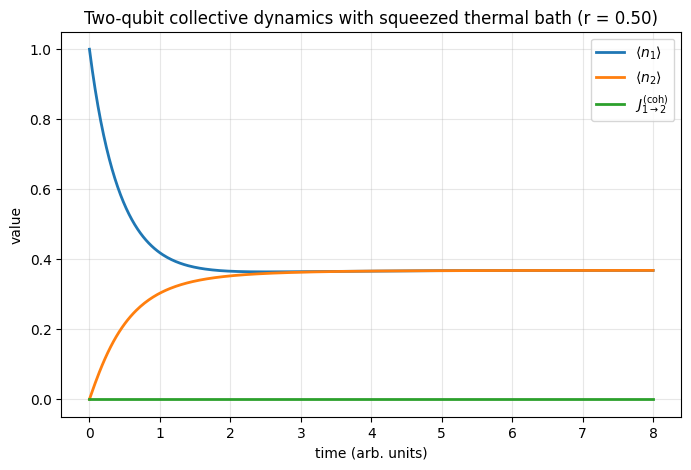

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
w0 = 1.0       # qubit frequency
gamma = 1.0    # decay rate scale
r = 0.5        # squeezing parameter
phi = 0.5      # squeezing phase
eta = 1.0      # collective coupling (C_12)
N = 0.2

# Derived parameters
Ntilde = N * (np.sinh(r)**2 + np.cosh(r)**2) + np.sinh(r)**2
M = - 0.5 * np.sinh(2*r) * np.exp(1j*phi) * (2*N + 1)

# Operators
Nq = 2
sm_list = [tensor([destroy(2) if m==n else qeye(2) for m in range(Nq)]) for n in range(Nq)]
sp_list = [s.dag() for s in sm_list]

# Collective coupling matrix
C = np.array([[1.0, eta],
              [eta, 1.0]])

# Lindblad superoperator with cross terms
def L_squeezed():
    L = 0
    for i in range(Nq):
        for j in range(Nq):
            # emission
            L += gamma*C[i,j]*(Ntilde+1) * (spre(sm_list[i]) * spost(sp_list[j]) -
                                            0.5*spre(sp_list[j]*sm_list[i]) -
                                            0.5*spost(sp_list[j]*sm_list[i]))
            # absorption
            L += gamma*C[i,j]*Ntilde * (spre(sp_list[i]) * spost(sm_list[j]) -
                                        0.5*spre(sm_list[j]*sp_list[i]) -
                                        0.5*spost(sm_list[j]*sp_list[i]))
            # two-photon correlations (squeezing terms)
            L += -gamma*C[i,j]*M * (spre(sp_list[i]) * spost(sp_list[j]) -
                                     0.5*spre(sp_list[j]*sp_list[i]) -
                                     0.5*spost(sp_list[j]*sp_list[i]))
            L += -gamma*C[i,j]*np.conj(M) * (spre(sm_list[i]) * spost(sm_list[j]) -
                                              0.5*spre(sm_list[j]*sm_list[i]) -
                                              0.5*spost(sm_list[j]*sm_list[i]))
    return L


H = 0 * tensor(qeye(2), qeye(2))   # zero Hamiltonian
L = liouvillian(H) + L_squeezed()  # full Liouvillian

# Initial state |10>
psi0 = tensor(basis(2,1), basis(2,0))
rho0 = ket2dm(psi0)

# Time evolution
tlist = np.linspace(0, 8, 400)
result = mesolve(L, rho0, tlist, [], 
                 e_ops=[sm_list[0].dag()*sm_list[0],
                        sm_list[1].dag()*sm_list[1],
                        1j*(sp_list[0]*sm_list[1] - sp_list[1]*sm_list[0])])

# Extract
n1 = result.expect[0]
n2 = result.expect[1]
Jcur = np.real(result.expect[2])

# Plot
plt.figure(figsize=(8,5))
plt.plot(tlist, n1, label=r'$\langle n_1 \rangle$', lw=2)
plt.plot(tlist, n2, label=r'$\langle n_2 \rangle$', lw=2)
plt.plot(tlist, Jcur, label=r'$J^{(\mathrm{coh})}_{1\to 2}$', lw=2)
plt.xlabel("time (arb. units)")
plt.ylabel("value")
plt.legend()
plt.title(f"Two-qubit collective dynamics with squeezed thermal bath (r = {r:.2f})")
plt.grid(True, alpha=0.3)
plt.show()


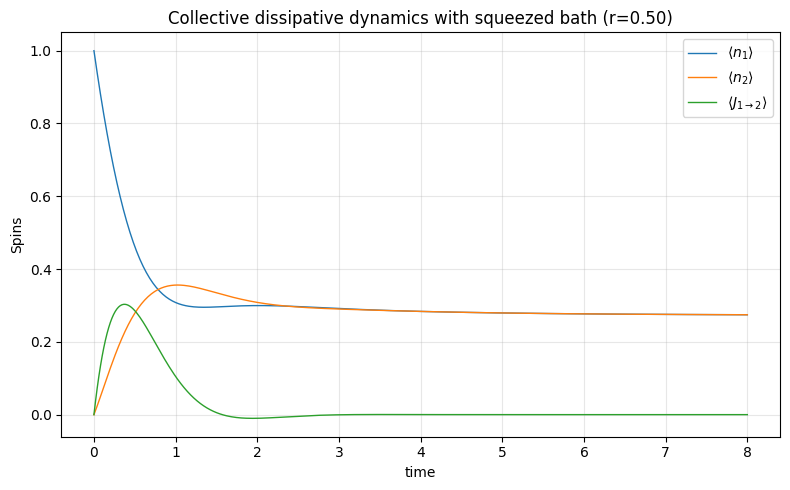

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

Gamma = 1.0
Eta = 0.8
r = 0.5
phi = 0.5
Nq = 2
N = 0.2
omega_1, omega_2 = 1.0, 1.0
omega = [omega_1, omega_2]
Omega_12 = Omega_21 = 1.0
Omega = [[0.0, Omega_12],
         [Omega_21, 0.0]]

N_tilde = N * (np.sinh(r)**2 + np.cosh(r)**2) + np.sinh(r)**2
M = - 0.5 * np.sinh(2*r) * np.exp(1j*phi) * (2*N + 1)

sm = [qt.tensor([qt.destroy(2) if m==n else qt.qeye(2) for m in range(Nq)]) for n in range(Nq)]
sp = [s.dag() for s in sm]
I_sys = qt.tensor([qt.qeye(2) for _ in range(Nq)])
sz = [2*sp[i]*sm[i] - I_sys for i in range(Nq)]
n1 = sp[0]*sm[0]
n2 = sp[1]*sm[1]

H = qt.qzero([Nq, Nq])

for i in range(Nq):
    H += omega[i] * sz[i]
    for j in range(Nq):
        if i != j:
            H += Omega[i][j] * sp[i] * sm[j]

J_op = 1j*Omega_12*(sp[0]*sm[1] - sp[1]*sm[0])

C = np.array([[1.0, Eta],
              [Eta, 1.0]], dtype=complex)

def D_super(A, B):
    return qt.spre(A) * qt.spost(B) - 0.5*qt.spre(B*A) - 0.5*qt.spost(B*A)

L = -1j*(qt.spre(H) - qt.spost(H))

for i in range(Nq):
    for j in range(Nq):
        Gamma_ij = Gamma*C[i,j]
        L += Gamma_ij*(N_tilde +1) * D_super(sm[i], sp[j])
        L += Gamma_ij * N_tilde * D_super(sp[i], sm[j])
        if M != 0:
            L += -Gamma_ij*M * D_super(sp[i], sp[j])
            L += -Gamma_ij*np.conj(M) * D_super(sm[i], sm[j])

rho0 = qt.ket2dm(qt.tensor(qt.basis(2,1), qt.basis(2,0)))

tlist = np.linspace(0, 8, 400)
result = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[n1, n2, J_op])

n1_t  = np.real(result.expect[0])
n2_t  = np.real(result.expect[1])
J_t   = np.real(result.expect[2])

plt.figure(figsize=(8,5))
plt.plot(tlist, n1_t, label=r'$\langle n_1\rangle$', lw=1.0)
plt.plot(tlist, n2_t, label=r'$\langle n_2\rangle$', lw=1.0)
plt.plot(tlist, J_t,  label=r'$\langle J_{1\to2}\rangle$', lw=1.0)
plt.xlabel("time")
plt.ylabel("Spins")
plt.title(f"Collective dissipative dynamics with squeezed bath (r={r:.2f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

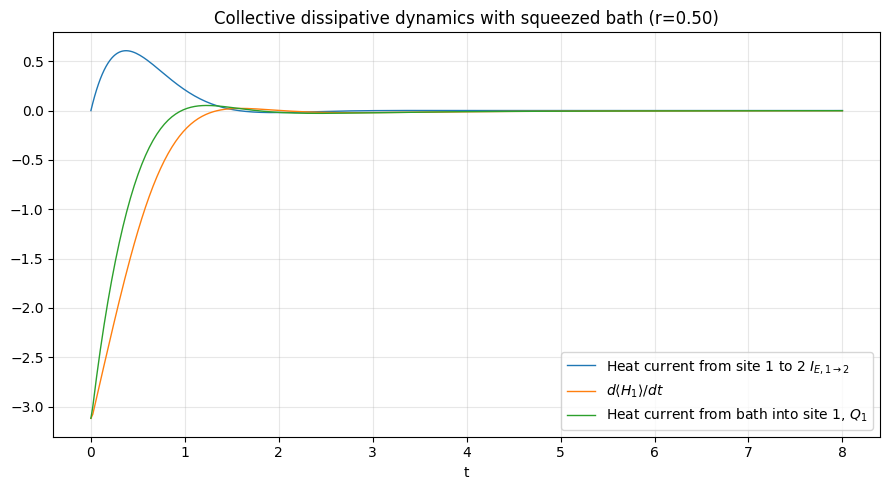

In [14]:
H1 = omega[0] * sz[0]
H2 = omega[1] * sz[1]

result = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[n1, n2, J_op, H1])

n1_t  = np.real(result.expect[0])
n2_t  = np.real(result.expect[1])
J_t   = np.real(result.expect[2])
H1_t  = np.real(result.expect[3])

I_E_t = 2.0 * omega[0] * J_t

dH1_dt = np.gradient(H1_t, tlist)

Q1_t = dH1_dt + I_E_t

plt.figure(figsize=(9,5))
plt.plot(tlist, I_E_t, label='Heat current from site 1 to 2 $I_{E,1\\to2}$', lw=1.0)
plt.plot(tlist, dH1_dt, label=r'$d\langle H_1\rangle/dt$', lw=1.0)
plt.plot(tlist, Q1_t, label='Heat current from bath into site 1, $Q_1$', lw=1.0)
plt.title(f"Collective dissipative dynamics with squeezed bath (r={r:.2f})")
plt.legend()
plt.xlabel('t')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

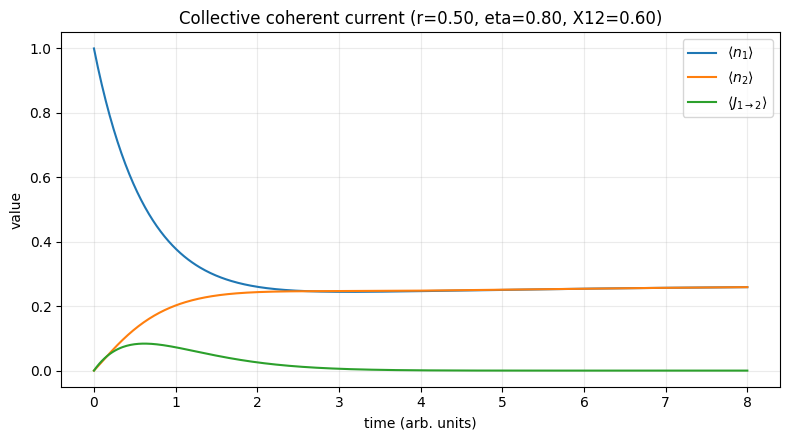

In [1]:
"""
Collective coherent spin current J_{1->2}(t) for two qubits in a squeezed-thermal collective bath.
Master equation used:
 dρ = -i[H_LS,ρ] + sum_{i,j} C_{ij} [ (Ntilde+1) D[σ_i^-,σ_j^+] + Ntilde D[σ_i^+,σ_j^-]
                                   - M D[σ_i^+,σ_j^+] - M* D[σ_i^-,σ_j^-] ]
where D[A,B]ρ = A ρ B - 1/2 { B A , ρ }.

Author: adapted for your system. Run with Python + QuTiP.
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ---------------- Parameters (change as needed) ----------------
Gamma = 1.0      # base spontaneous rate (C_ii = Gamma)
eta   = 0.8      # collective coupling factor (C_12 = eta * Gamma)
X12   = 0.6      # coherent exchange parameter (appears in H_LS and current)
r     = 0.50     # squeezing parameter (set r=0 for no squeezing)
phi   = 0.0      # squeezing phase
t_max = 8.0
n_t   = 500

# -------- Derived bath parameters ----------
Ntilde = np.sinh(r)**2
M = np.sinh(r)*np.cosh(r)*np.exp(1j*phi)   # two-photon correlation from squeezing

# -------- Two-qubit operators ----------
Nq = 2
sm = [tensor([destroy(2) if m==n else qeye(2) for m in range(Nq)]) for n in range(Nq)]
sp = [s.dag() for s in sm]
n1 = sp[0]*sm[0]
n2 = sp[1]*sm[1]

# -------- Lamb-shift Hamiltonian ----------
H_LS = 0.5 * X12 * (sp[0]*sm[1] + sp[1]*sm[0])   # Hermitian

# -------- Hermitian coherent current operator ----------
J_op = 1j * X12 * (sp[0]*sm[1] - sp[1]*sm[0])    # expectation = 2 Im[S12 <s1+ s2->]

# -------- Collective coupling matrix C_ij ----------
C = Gamma * np.array([[1.0, eta],
                      [eta, 1.0]], dtype=complex)

# -------- Build Liouvillian (superoperator) ----------
def D_super(A, B):
    # Superoperator for D[A,B] : repr as Qobj
    return spre(A) * spost(B) - 0.5 * spre(B * A) - 0.5 * spost(B * A)

L = -1j * (spre(H_LS) - spost(H_LS))   # -i[H_LS, ·]

for i in range(Nq):
    for j in range(Nq):
        Cij = C[i, j]
        # emission (Ntilde + 1)
        L += Cij * (Ntilde + 1.0) * D_super(sm[i], sp[j])
        # absorption (Ntilde)
        L += Cij * Ntilde * D_super(sp[i], sm[j])
        # two-photon squeezing terms
        if np.abs(M) > 0:
            L += -Cij * M * D_super(sp[i], sp[j])
            L += -Cij * np.conj(M) * D_super(sm[i], sm[j])

# -------- initial state and time grid ----------
rho0 = ket2dm(tensor(basis(2,1), basis(2,0)))  # |10><10|
tlist = np.linspace(0, t_max, n_t)

# -------- solve (mesolve accepts a Liouvillian Qobj as first argument) ----------
# e_ops: n1, n2, and J_op
result = mesolve(L, rho0, tlist, [], e_ops=[n1, n2, J_op])

n1_t = np.real(result.expect[0])
n2_t = np.real(result.expect[1])
J_t  = np.real(result.expect[2])

# -------- plot ----------
plt.figure(figsize=(8,4.5))
plt.plot(tlist, n1_t, label=r'$\langle n_1\rangle$')
plt.plot(tlist, n2_t, label=r'$\langle n_2\rangle$')
plt.plot(tlist, J_t,  label=r'$\langle J_{1\to2}\rangle$')
plt.xlabel('time (arb. units)')
plt.ylabel('value')
plt.title(f'Collective coherent current (r={r:.2f}, eta={eta:.2f}, X12={X12:.2f})')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


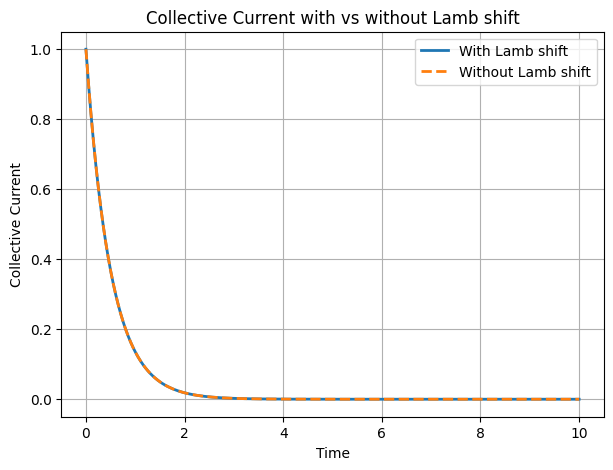

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
N = 2              # number of two-level systems (qubits)
gamma = 1.0        # decay rate
delta = 0.5        # Lamb shift coupling strength
tlist = np.linspace(0, 10, 200)

# Basis operators
sm_list = [tensor([destroy(2) if m == n else qeye(2) for m in range(N)]) for n in range(N)]
sp_list = [s.dag() for s in sm_list]
sz_list = [sp_list[n]*sm_list[n] - sm_list[n]*sp_list[n] for n in range(N)]

# Collective operators
Jm = sum(sm_list)
Jp = Jm.dag()

# Hamiltonians
H0 = 0.0 * Jp * Jm  # Free part can be zero for this demo
H_LS = delta * Jp * Jm   # Lamb shift term (collective energy shift)

# Collapse operators
c_ops = [np.sqrt(gamma) * Jm]

# Initial state: one excitation in first qubit
psi0 = tensor(basis(2,1), basis(2,0))

# Function to compute current (expectation of emission rate)
def collective_current(rho_t):
    return expect(Jp*Jm, rho_t) * gamma

# Solve dynamics with Lamb shift
res_with = mesolve(H0 + H_LS, psi0, tlist, c_ops=c_ops, e_ops=[])
I_with = [collective_current(r) for r in res_with.states]

# Solve dynamics without Lamb shift
res_without = mesolve(H0, psi0, tlist, c_ops=c_ops, e_ops=[])
I_without = [collective_current(r) for r in res_without.states]

# Plot
plt.figure(figsize=(7,5))
plt.plot(tlist, I_with, label="With Lamb shift", lw=2)
plt.plot(tlist, I_without, '--', label="Without Lamb shift", lw=2)
plt.xlabel("Time")
plt.ylabel("Collective Current")
plt.legend()
plt.title("Collective Current with vs without Lamb shift")
plt.grid(True)
plt.show()

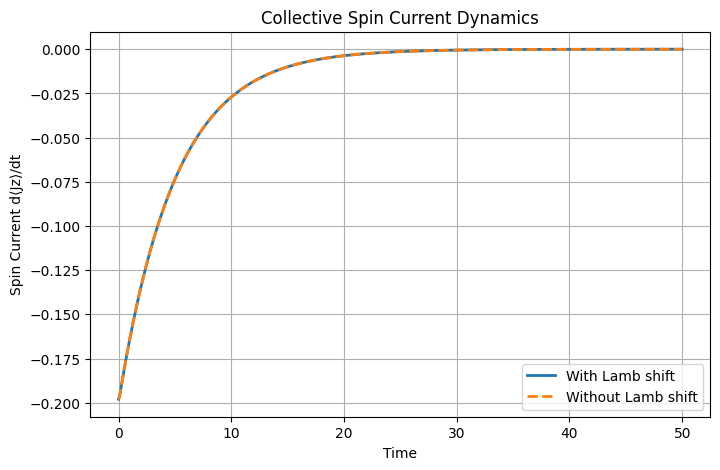

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
gamma = 0.1   # decay rate
omega = 1.0   # qubit frequency
lamb_shift = 0.05  # Lamb shift strength
tlist = np.linspace(0, 50, 500)

# Operators
sm1 = tensor(sigmam(), qeye(2))
sm2 = tensor(qeye(2), sigmam())
sp1 = sm1.dag()
sp2 = sm2.dag()
sz1 = tensor(sigmaz(), qeye(2))
sz2 = tensor(qeye(2), sigmaz())

# Collective operators
Jm = sm1 + sm2
Jp = Jm.dag()
Jz = sz1 + sz2

# Initial state: one excitation in first qubit
psi0 = tensor(basis(2,1), basis(2,0))

# Hamiltonians
H0 = omega * (sz1 + sz2)/2
H_ls = lamb_shift * (sp1*sm2 + sp2*sm1)   # Lamb shift coupling

# With Lamb shift
H_with_ls = H0 + H_ls
# Without Lamb shift
H_without_ls = H0

# Collapse operators (collective dissipation)
c_ops = [np.sqrt(gamma) * Jm]

# Solve master equation
res_with = mesolve(H_with_ls, psi0, tlist, c_ops, [Jz])
res_without = mesolve(H_without_ls, psi0, tlist, c_ops, [Jz])

# Compute spin current = d⟨Jz⟩/dt
J_with = np.gradient(np.real(res_with.expect[0]), tlist)
J_without = np.gradient(np.real(res_without.expect[0]), tlist)

# Plot
plt.figure(figsize=(8,5))
plt.plot(tlist, J_with, label="With Lamb shift", lw=2)
plt.plot(tlist, J_without, label="Without Lamb shift", lw=2, ls="--")
plt.xlabel("Time")
plt.ylabel("Spin Current d⟨Jz⟩/dt")
plt.title("Collective Spin Current Dynamics")
plt.legend()
plt.grid()
plt.show()
